# Occupacy as a time dependent variable

By plotting each station data as a time series (previous notebook) we saw that occupacy has a daily seasonality wich is also dependent on the day of the week (weekdays vs weekends). In this notebook we'll be use GAMs to find the effect of time on station occupacy. At the beginning the process is described for one single station and at the end the same process is aplied to all station altogether.

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
import warnings
warnings.filterwarnings('ignore')

Load a random CSVs from the stack

In [3]:
master = pd.read_csv('../stations-dataset/station-26.csv', parse_dates=['timestamp'])

In [4]:
master.head()

,timestamp,dailyRain,pressure,rainIntensity,temperature,windVelocity,id,bicycles,free_positions,status
0,2018-06-11 00:40:00,0.0,1005.95,0.0,14.40,3.2,2.0,2.0,25.0,En Operación
1,2018-06-11 00:45:00,0.0,1005.95,0.0,14.40,3.2,3.0,2.0,25.0,En Operación
2,2018-06-11 00:50:00,0.0,1005.92,0.0,14.35,4.0,4.0,2.0,25.0,En Operación
3,2018-06-11 00:55:00,0.0,1005.90,0.0,14.30,4.8,5.0,2.0,25.0,En Operación
4,2018-06-11 01:00:00,0.0,1005.90,0.0,14.30,4.8,6.0,2.0,25.0,En Operación


## Tidying

For our model we will be defining occupacy as a ratio between the number of docked at each observation bikes in relationship to the total of slots in each station. Time should be transformed as a continous variable in order to have a smooth curve that spans an entire day. The effects of time on occupacy will be adjusted for weather variables and weekday number.

In [5]:
master = master.drop(['id'], axis = 1) # Drops unnecesary column

#### Occupacy

Normalize capacity by calculating the percentage of occupacy as a ratio of docked bicycles and total slots (bicycles + free_positions)

In [6]:
master['bicycles'] = master['bicycles'].divide((master['bicycles'].add(master['free_positions'])))

In [7]:
master['bicycles'] = master['bicycles'].apply(lambda x: round(x,2))

In [8]:
master = master.drop(['free_positions'], axis = 1)

#### Time as a continous variable

Create a new continous variable that represents how much of the current day has passed by. For this, we will convert everything to seconds and divide the result by the total of second on a given day (86400).

In [9]:
hour_to_sec = master.timestamp.dt.hour.multiply(3600)
minu_to_sec = master.timestamp.dt.minute.multiply(60)

In [10]:
total_seconds = hour_to_sec.add(minu_to_sec)

In [11]:
master['time'] = total_seconds.divide(86400)

#### Get the day of the week as an integer

In [12]:
master['weekday'] = master.timestamp.dt.weekday

#### Drop missing observation and unnecessary columns

In [13]:
master = master.loc[master['status'] == 'En Operación']

In [14]:
master = master.drop(['status'], axis = 1)

#### Tidy data

In [15]:
master.head() # Ready to rock

,timestamp,dailyRain,pressure,rainIntensity,temperature,windVelocity,bicycles,time,weekday
0,2018-06-11 00:40:00,0.0,1005.95,0.0,14.40,3.2,0.07,0.027778,0
1,2018-06-11 00:45:00,0.0,1005.95,0.0,14.40,3.2,0.07,0.031250,0
2,2018-06-11 00:50:00,0.0,1005.92,0.0,14.35,4.0,0.07,0.034722,0
3,2018-06-11 00:55:00,0.0,1005.90,0.0,14.30,4.8,0.07,0.038194,0
4,2018-06-11 01:00:00,0.0,1005.90,0.0,14.30,4.8,0.07,0.041667,0


## pyGAM

In [16]:
from pygam import LinearGAM

In [17]:
X = master[['time', 'weekday', 'temperature', 'rainIntensity', 'dailyRain', 'windVelocity', 'pressure']]
y = master['bicycles']

In [ ]:
gam = LinearGAM(n_splines=10).gridsearch(X, y)

In [21]:
XX = gam.generate_X_grid()

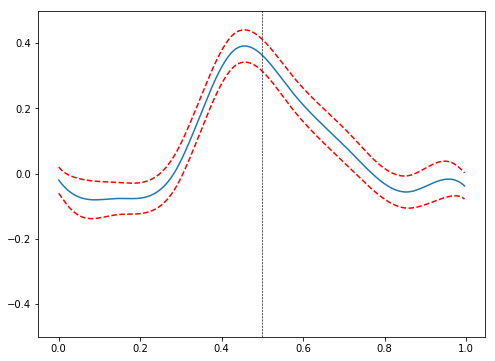

In [27]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
pdep, confi = gam.partial_dependence(XX, feature=0, width=.95)
ax.plot(XX[:, 0], pdep)
ax.plot(XX[:, 0], *confi, c='r', ls='--')
ax.set_ylim(-0.5,0.5)
ax.axvline(0.5,  lw=0.6, ls='--', c='black')
plt.show()

In [33]:
len(XX)

500

### Conclusions

For stations number 26, after adjusting for day of the week and weather, time dependent occupacy produce a curve with one mode and peaks just one hour before 12pm.

## Repeat for all stations

In [35]:
from tqdm import tqdm

Load stations ids

In [36]:
stations = pd.read_csv('../misc_datasets/stations_info.csv') # Info about individual stations
stations = stations.loc[~stations['id'].isin([3, 29, 54, 68, 137, 219, 203, 217, 165])]

Function for fast CSVs loading

In [37]:
def station(number):
    df = pd.read_csv(f'../stations-dataset/station-{number}.csv', parse_dates=['timestamp'])    
    return df

Creates a dataframe were to store all data points from the curves to use later in unsupervised classification

In [43]:
time_dependence_set = pd.DataFrame()

In [ ]:
for station_id in tqdm(stations['id']):
    master = station(station_id)
    
    master['bicycles'] = master['bicycles'].divide((master['bicycles'].add(master['free_positions'])))
    master['bicycles'] = master['bicycles'].apply(lambda x: round(x,2))
    
    hour_to_sec = master.timestamp.dt.hour.multiply(3600)
    minu_to_sec = master.timestamp.dt.minute.multiply(60)
    total_seconds = hour_to_sec.add(minu_to_sec)
    master['time'] = total_seconds.divide(86400)
    
    master['weekday'] = master.timestamp.dt.weekday
    
    master = master.loc[master['status'] == 'En Operación']
    
    X = master[['time', 'weekday', 'temperature', 'rainIntensity', 'dailyRain', 'windVelocity', 'pressure']]
    y = master['bicycles']
    
    del master
    
    gam = LinearGAM(n_splines=10, verbose=False).gridsearch(X, y)
    XX = gam.generate_X_grid()
    pdep, confi = gam.partial_dependence(XX, feature=0, width=.95)
    
    del gam
    
    time_dependence_set[str(station_id)] = pdep.flatten()

    fig, ax = plt.subplots(1,1, figsize=(8,6))
    pdep, confi = gam.partial_dependence(XX, feature=0, width=.95)
    ax.plot(XX[:, 0], pdep)
    ax.plot(XX[:, 0], *confi, c='r', ls='--')
    ax.set_ylim(-0.5,0.5)
    ax.axvline(0.5,  lw=0.6, ls='--', c='black')
    
    plt.savefig(f'../plots/occupacy_time_dependent/station-{station_id}.png')
    plt.clf()

In [63]:
time_series = time_dependence_set.T.values

In [174]:
cluster_num = 5

In [178]:
clusters = kshape(zscore(time_series, axis=1), cluster_num)

/home/bavio/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


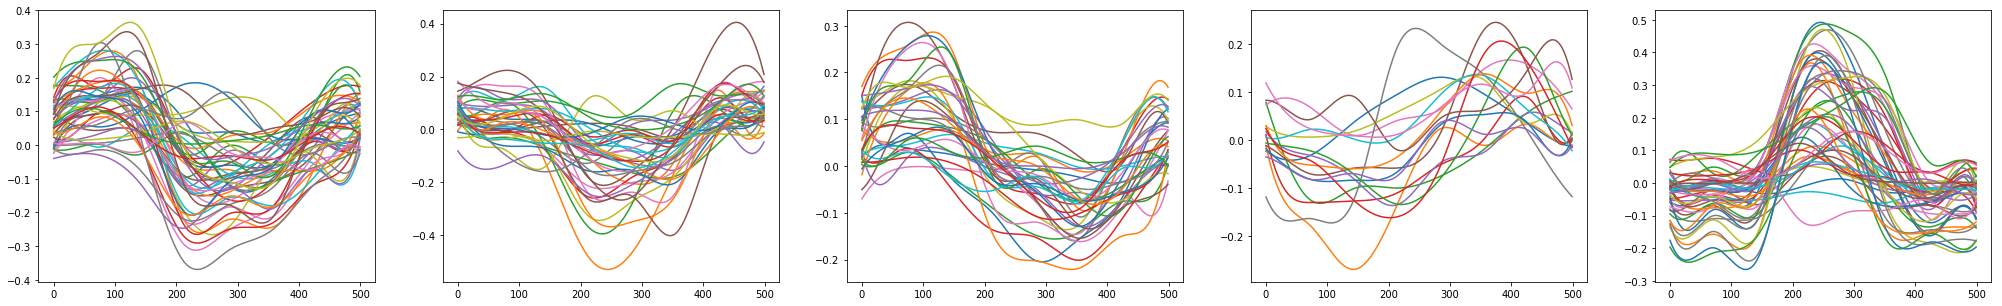

In [179]:
fig, axes =  plt.subplots(1, len(clusters), figsize=((len(clusters)*7),5))

for i,ax in enumerate(axes):
    pd.DataFrame(time_series[clusters[i][1]]).T.plot(ax = ax)
    ax.legend().set_visible(False)

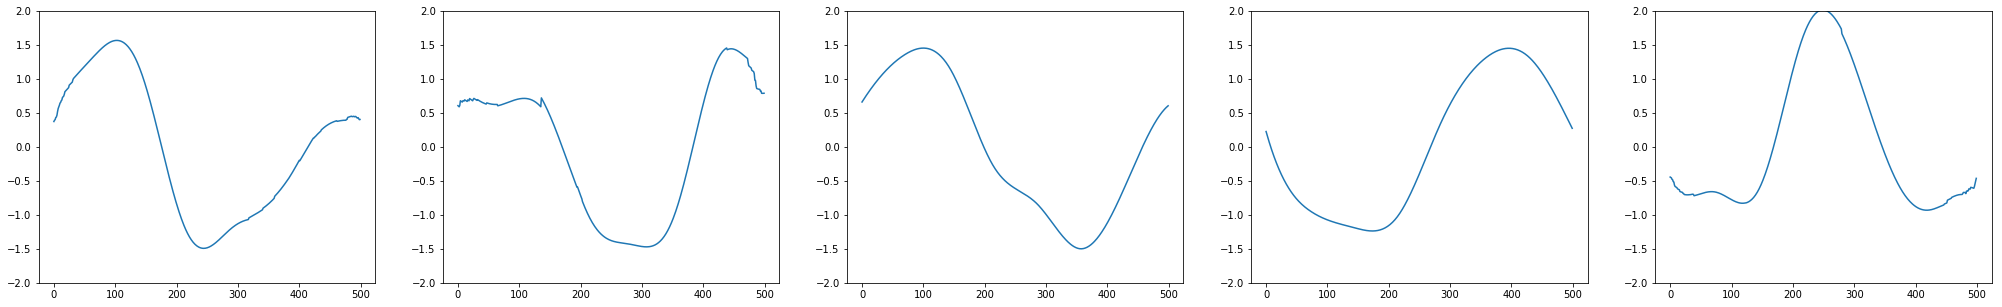

In [180]:
fig, axes =  plt.subplots(1, len(clusters), figsize=((len(clusters)*7),5))

for i,ax in enumerate(axes):
    ax.plot(clusters[i][0])
    ax.set_ylim(-2,2)